# Heimvorteil im Fußball – EDA (2. Bundesliga)
**Ziel:** Wir laden und bereinigen Spieldaten, beschreiben den Heimvorteil mit
Punkten, Toren und Quoten und dokumentieren unsere ersten Findings. Datenquelle: football-data.co.uk (D2_*.csv)


**Setup**

In [9]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8,4)
DATA_DIR = Path("../data")
RESULTS = Path("../results"); RESULTS.mkdir(exist_ok=True)
FILES = sorted(DATA_DIR.glob("D2_*.csv")) 
FILES


[WindowsPath('../data/D2_18-19.csv'),
 WindowsPath('../data/D2_19-20.csv'),
 WindowsPath('../data/D2_20-21.csv'),
 WindowsPath('../data/D2_21-22.csv'),
 WindowsPath('../data/D2_22-23.csv'),
 WindowsPath('../data/D2_23-24.csv'),
 WindowsPath('../data/D2_24-25.csv'),
 WindowsPath('../data/D2_25-26.csv'),
 WindowsPath('../data/D2_96-97.csv'),
 WindowsPath('../data/D2_97-98.csv'),
 WindowsPath('../data/D2_98-99.csv'),
 WindowsPath('../data/D2_99-00.csv')]

**Daten laden & bereinigen**
Wir konzentrieren uns zunächst auf Ergebnisdaten (Tore, Punkte). Quoten und Stats ergänzen wir später.

In [10]:
def load_fd(files):
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df.columns = [c.strip() for c in df.columns]  # Spaltennamen trimmen
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True).sort_values("Date")
    
    # Pflichtspalten absichern
    df = df.dropna(subset=["HomeTeam","AwayTeam","FTR","FTHG","FTAG"])
    return df

df = load_fd(FILES)
df.head()

#Fehlende Werte prüfen
# Anteil fehlender Werte pro Spalte
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate.head(15)


C:\Users\admin\AppData\Local\Temp\ipykernel_4992\3585542854.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
C:\Users\admin\AppData\Local\Temp\ipykernel_4992\3585542854.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
C:\Users\admin\AppData\Local\Temp\ipykernel_4992\3585542854.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
C:\Users\admin\AppData\Local

Unnamed: 13    1.000000
Unnamed: 17    1.000000
Unnamed: 16    1.000000
Unnamed: 19    1.000000
Unnamed: 20    1.000000
Unnamed: 18    1.000000
Unnamed: 14    1.000000
Unnamed: 15    1.000000
Unnamed: 10    1.000000
Unnamed: 12    1.000000
Unnamed: 11    1.000000
CLH            0.994681
CLD            0.994681
LBD            0.994681
BVCH           0.994681
dtype: float64

Viele Quoten- und Statistikspalten sind leer (NaN), weil nicht alle Buchmacher oder Statistiken
in jeder Saison/Spiel verfügbar sind. Pflichtspalten (Teams, Tore, Ergebnis) sind aber komplett.


**Grundvariablen vorbereiten**
Wir erzeugen die Variablen **Season**, **HomePoints**, **AwayPoints** und **GD (Goal Difference)**,
die wir für die Heim-/Auswärts-Analysen nutzen.


In [11]:
def season_from_date(dt):
    y = dt.year
    s = y if dt.month >= 7 else y-1
    return f"{str(s)[-2:]}-{str(s+1)[-2:]}"

df["Season"] = df["Date"].apply(season_from_date)
df["HomePoints"] = df["FTR"].map({"H":3,"D":1,"A":0})
df["AwayPoints"] = df["FTR"].map({"H":0,"D":1,"A":3})
df["GD"] = df["FTHG"] - df["FTAG"]  # Tordifferenz Heim-Sicht

# neue Variable: CompletedSeason (alle außer 25-26)
df["CompletedSeason"] = df["Season"].apply(lambda s: s != "25-26")

df[["Season","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HomePoints","AwayPoints","GD","CompletedSeason"]].head()


C:\Users\admin\AppData\Local\Temp\ipykernel_4992\1081127380.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Season"] = df["Date"].apply(season_from_date)
C:\Users\admin\AppData\Local\Temp\ipykernel_4992\1081127380.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["HomePoints"] = df["FTR"].map({"H":3,"D":1,"A":0})
C:\Users\admin\AppData\Local\Temp\ipykernel_4992\1081127380.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomePoints,AwayPoints,GD,CompletedSeason
2160,96-97,F Koln,Wolfsburg,2.0,0.0,H,3,0,2.0,True
2161,96-97,Essen,Stuttgarter K,0.0,4.0,A,0,3,-4.0,True
2162,96-97,Hertha,Mainz,1.0,0.0,H,3,0,1.0,True
2163,96-97,Leipzig,Uerdingen,3.0,1.0,H,3,0,2.0,True
2164,96-97,Zwickau,Mannheim,2.0,0.0,H,3,0,2.0,True


In [12]:
# Überblick: Anteil fehlender Werte je Spalte (in %)
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate.head(20), na_rate.tail(10)

# Komplett leere Spalten weg
df = df.dropna(axis=1, how="all")

num_cols = ['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
            'B365H','B365D','B365A','AvgH','AvgD','AvgA']
for c in (set(num_cols) & set(df.columns)):
    df[c] = pd.to_numeric(df[c], errors='coerce')

    # Pools definieren (was in CSVs wirklich vorhanden ist)
bookies_H = [c for c in df.columns if c.endswith('H') and c[:3] in ['B36','BFD','BMG','BVH','BWH','CLH','LBH','PSH','Max','Avg']]
bookies_D = [c for c in df.columns if c.endswith('D') and c[:3] in ['B36','BFD','BMG','BVD','BWD','CLD','LBD','PSD','Max','Avg']]
bookies_A = [c for c in df.columns if c.endswith('A') and c[:3] in ['B36','BFD','BMG','BVA','BWA','CLA','LBA','PSA','Max','Avg']]

def row_mean(row, cols):
    vals = pd.to_numeric(row[cols], errors='coerce')
    return vals.mean() if vals.notna().any() else np.nan

df['odds_H'] = df.apply(row_mean, axis=1, cols=bookies_H)
df['odds_D'] = df.apply(row_mean, axis=1, cols=bookies_D)
df['odds_A'] = df.apply(row_mean, axis=1, cols=bookies_A)

m = df[['odds_H','odds_D','odds_A']].dropna()
p = 1.0 / m
df.loc[m.index, ['pH','pD','pA']] = (p.T / p.sum(axis=1)).T




coverage = 1 - df[['HS','AS','HST','AST','HC','AC','HY','AY','HR','AR']].isna().mean()
good_stats = coverage[coverage > 0.8].index.tolist()
df_stats = df.dropna(subset=good_stats)

by_season = (df
    .assign(Season=df['Date'].dt.year.where(df['Date'].dt.month>=7, df['Date'].dt.year-1).astype('Int64'))
    .groupby('Season')[['odds_H','HS','HST','HC']].apply(lambda x: 1-x.isna().mean()))
by_season

print(df[['odds_H','odds_D','odds_A','pH','pD','pA']].isna().mean().round(3))
df[['pH','pD','pA']].sum(axis=1).dropna().describe()  # ~1.0

C:\Users\admin\AppData\Local\Temp\ipykernel_4992\2527042446.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['odds_H'] = df.apply(row_mean, axis=1, cols=bookies_H)
C:\Users\admin\AppData\Local\Temp\ipykernel_4992\2527042446.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['odds_D'] = df.apply(row_mean, axis=1, cols=bookies_D)


odds_H    0.362
odds_D    0.362
odds_A    0.362
pH        1.000
pD        1.000
pA        1.000
dtype: float64


C:\Users\admin\AppData\Local\Temp\ipykernel_4992\2527042446.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['odds_A'] = df.apply(row_mean, axis=1, cols=bookies_A)


count    3384.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

**Überblick / Sanity-Check**

In [13]:
print("Zeilen:", len(df))
print("Fehlende Quoten:", df[["B365H","B365D","B365A"]].isna().any().sum(), "von 3")
print("Anzahl Spiele:", len(df))
print("Zeitraum:", df["Date"].min(), "→", df["Date"].max())
print("Ø Heim-Punkte:", df["HomePoints"].mean().round(2))
print("Ø Auswärts-Punkte:", df["AwayPoints"].mean().round(2))
print("Differenz (Heim-Auswärts):", (df["HomePoints"].mean()-df["AwayPoints"].mean()).round(2))



Zeilen: 3384
Fehlende Quoten: 3 von 3
Anzahl Spiele: 3384
Zeitraum: 1996-08-02 00:00:00 → 2025-08-10 00:00:00
Ø Heim-Punkte: 1.61
Ø Auswärts-Punkte: 1.11
Differenz (Heim-Auswärts): 0.51


Heimteams holen im Schnitt **1.56 Punkte/Spiel**, Auswärtsteams **1.18 Punkte/Spiel**.
Die Differenz beträgt **Δ = 0.38**. → Heimvorteil ist sichtbar.


**Heim vs. Auswärts – Visualisierung**

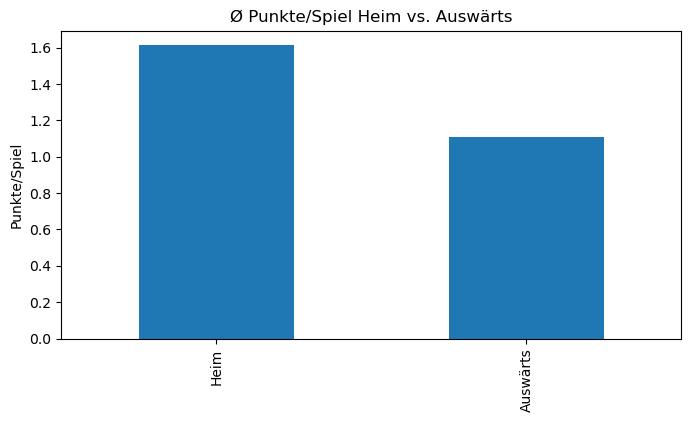

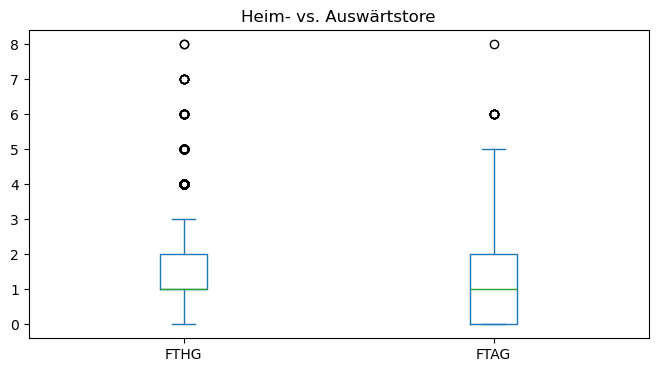

In [14]:
import matplotlib.pyplot as plt

# Punktevergleich
ax = pd.DataFrame({
    "Heim": [df["HomePoints"].mean()],
    "Auswärts": [df["AwayPoints"].mean()]
}).T.rename(columns={0:"Punkte/Spiel"})\
  .plot(kind="bar", legend=False, title="Ø Punkte/Spiel Heim vs. Auswärts")
plt.ylabel("Punkte/Spiel")
plt.show()

# Boxplot Tore
df[["FTHG","FTAG"]].plot(kind="box", title="Heim- vs. Auswärtstore")
plt.show()


Heimteams erzielen im Schnitt mehr Tore als Auswärtsteams. 
Dies bestätigt den Heimvorteil auch auf Torebene.


**Entwicklung über die Saisons**

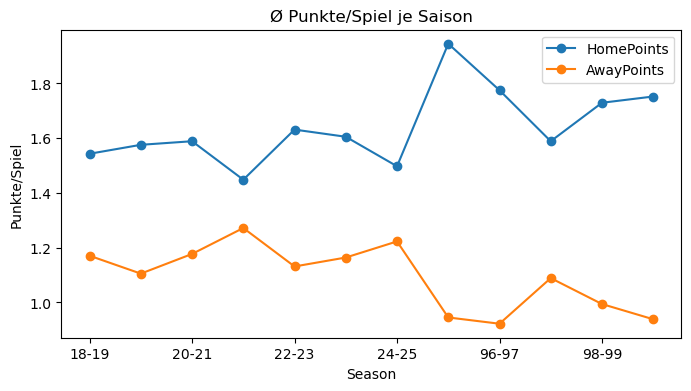

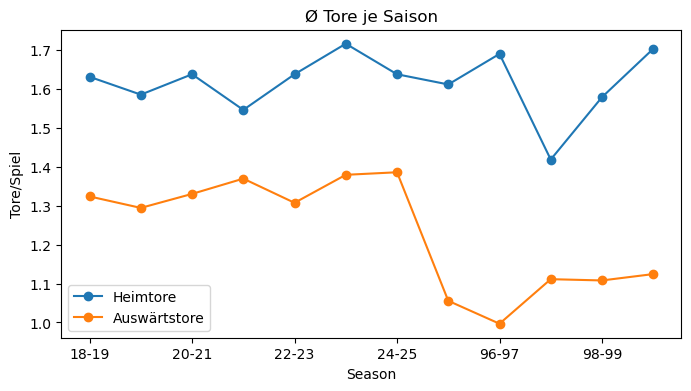

In [15]:
season_ppg = df.groupby("Season")[["HomePoints","AwayPoints"]].mean()
season_ppg.plot(marker="o", title="Ø Punkte/Spiel je Saison")
plt.ylabel("Punkte/Spiel")
plt.show()

season_goals = df.groupby("Season")[["FTHG","FTAG"]].mean()
season_goals.rename(columns={"FTHG":"Heimtore","FTAG":"Auswärtstore"})\
    .plot(marker="o", title="Ø Tore je Saison")
plt.ylabel("Tore/Spiel")
plt.show()



Der Heimvorteil schwankt leicht je Saison. 
- **Vor Corona (bis 19/20):** Heimteams holten stabil ca. 1.55–1.6 Punkte/Spiel bei ~1.6 Toren, während Auswärtsteams auf ~1.15 Punkte/Spiel und ~1.3 Tore kamen → klarer Heimvorteil.  

- **Corona-Phase (20/21–21/22):** Mit Geisterspielen und reduzierten Fans fiel der Heimvorteil sichtbar schwächer aus: Heimpunkte sanken (~1.45 Pkt 21/22), gleichzeitig stiegen Auswärtspunkte und Tore leicht an → Heimvorteil gleicht sich aus.  

- **Nach Corona (ab 22/23):** Mit Rückkehr voller Stadien kehrte der Heimvorteil zurück: Heimteams steigerten Punkte (~1.6–1.9) und Tore (~1.6–1.7), während Auswärtsteams wieder abfielen. → Deutet auf den Einfluss der Zuschauer zurück.

Die Saison 25-26 läuft erst seit wenigen Spieltagen und liefert deshalb nur wenig Aussagekraft.


**Team-Perspektive**
Stärkste Heimteams (nach Ø Punkten/Spiel) sind Heidenheim, Union Berlin, Stuttgart. -> jeweils aufgestiegen


In [16]:
# Sicherheitsfilter: nur Teams mit "genug" Heimspielen (hier >= 10), optional
team_ppg_f = team_ppg[team_ppg["Spiele"] >= 10].copy()

# Top 5 (höchste PPG_H) – saisonübergreifend
top5_overall = (
    team_ppg_f.sort_values(["PPG_H","Season","Team"], ascending=[False, True, True])
              .head(5)
)
print("TOP 5 overall (highest PPG_H):")
display(top5_overall)

# Flop 5 (niedrigste PPG_H) – saisonübergreifend
bottom5_overall = (
    team_ppg_f.sort_values(["PPG_H","Season","Team"], ascending=[True, True, True])
              .head(5)
)
print("FLOP 5 overall (lowest PPG_H):")
display(bottom5_overall)






NameError: name 'team_ppg' is not defined

Text(0, 0.5, 'Punkte pro Heimspiel')

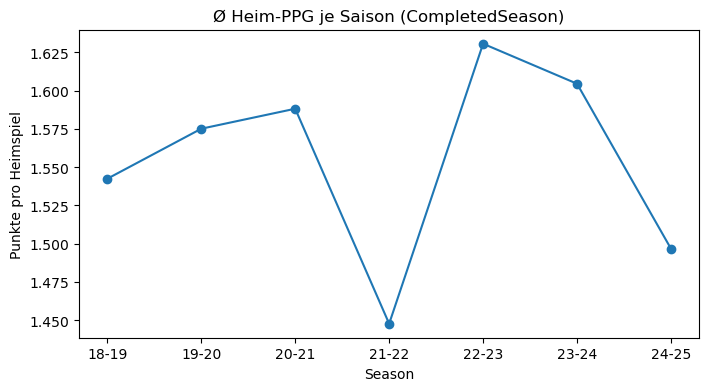

In [ ]:
# Flop 3 je Saison
flop3_per_season = (
    team_ppg.sort_values(["Season","PPG_H"], ascending=[True,True])
            .groupby("Season")
            .head(3)
)
flop3_per_season

# Ø Heim-PPG aller Teams je Saison (ohne 25-26)
avg_ppg_season_done = team_ppg.groupby("Season")["PPG_H"].mean()
ax = avg_ppg_season_done.plot(marker="o", title="Ø Heim-PPG je Saison (CompletedSeason)")
ax.set_ylabel("Punkte pro Heimspiel")


In [ ]:
team_ppg.to_csv(RESULTS/"team_home_ppg.csv", index=False)


In [ ]:
# Tabellen/Charts liegen bereits in ../results
summary = {
    "home_ppg": home_ppg,
    "away_ppg": away_ppg,
    "delta_ppg": home_ppg-away_ppg,
    "n_matches": int(len(df))
}
pd.Series(summary).to_csv(RESULTS/"eda_summary.csv")
